<a href="https://colab.research.google.com/github/jtdsouza/w251-WIldTrackAI/blob/master/WildAID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization and Load Image Data

In [1]:
#Set up Tensor flow 2.0

from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

TensorFlow 2.x selected.


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, BatchNormalization, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense, Dropout
from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.initializers import lecun_normal
from tensorflow.keras.initializers import he_uniform
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.initializers import glorot_normal
from tensorflow.keras import backend as K
from keras.preprocessing import image as KImage

import cv2
import csv
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
from google.colab.patches import cv2_imshow
from collections import defaultdict
import random
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as VGG16Pre
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input as VGG19Pre
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as InceptionPre
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input as XceptionPre
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as MNPre
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.nasnet import NASNetMobile
from tensorflow.keras.applications.densenet import DenseNet121

from tensorflow.keras.applications.imagenet_utils import preprocess_input

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Using TensorFlow backend.


In [3]:
#Mount Google Drive - Note this mounts your personal GDrive to the directory stated

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Load Images and setup Data Structures

Images are loaded from csv files that contain previously processed data sets.
The preprocessing implementation can be found here: https://colab.research.google.com/drive/1tVg9y71wbf_-bpgOue4LAFbCSXuu2SCD?usp=sharing

In [0]:
  #Set up path for csv files containing preprocessed images. Need to map U C Berkeley - Darragh/ shared to your personal GDrive for this to work. 
  csvpath='/content/drive/My Drive/U C Berkeley - Darragh/csv'

  #Function to load processed image data in csv files (both training and test, input data labels)
  def LoadData(train_imagefile="Training-Images-224.csv",train_labelfile="Training-Labels-224.txt",
               test_imagefile="Test-Images-224.csv",test_labelfile="Test-Labels-224.txt"):
    
    #Training Data Set
    X=[]
    Individuals=[]
    Species=[]
    Ind_DB=defaultdict(defaultdict)

    
    dataset=np.loadtxt(os.path.join(csvpath,train_imagefile),delimiter=",")
    f=open(os.path.join(csvpath,train_labelfile),'r')
    lines=f.readlines()
    for line in lines:
      vals=line.rstrip()
      Species.append(vals.split("-")[0])
      Individuals.append(vals)
    i=0
    for x in dataset:
      image=x.reshape(224,224,3)
      X.append(image)
      species=Species[i]
      key=Individuals[i]
      spec_DB=Ind_DB[species]
      if key not in spec_DB.keys():
        spec_DB[key]=[image]
      else:
        spec_DB[key].append(image)
      i=i+1


    #Test Data Set
    X_Test=[]
    Individuals_Test=[]
    Species_Test=[]
    dataset=np.loadtxt(os.path.join(csvpath,test_imagefile),delimiter=",")

    for x in dataset:
      image=x.reshape(224,224,3)
      X_Test.append(image)

    f=open(os.path.join(csvpath,test_labelfile),'r')
    lines=f.readlines()
    for line in lines:
      vals=line.rstrip()
      Species_Test.append(vals.split("-")[0])
      Individuals_Test.append(vals)

    X_Test=np.asarray(X_Test)
    X=np.asarray(X)
    return (X,Species,Individuals,Ind_DB,X_Test,Species_Test,Individuals_Test)

In [0]:
# Load Pre-Processed Images

X,Species,Individuals, Ind_DB,X_Test,Species_Test,Individuals_Test=LoadData()


In [6]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
le = LabelEncoder()
le.fit(Species)
Y=le.transform(Species)
Y_Test=le.transform(Species_Test)
Y1=to_categorical(np.array(Y))
Y_Test1=to_categorical(np.array(Y_Test))
print(Y1.shape)
print(le.classes_)
#For Species Classification
from sklearn.model_selection import train_test_split

X_Train, X_Val, Y_Train, Y_Val = train_test_split(X, Y1, test_size=0.10, random_state=42)

(1437, 8)
['Amur Tiger' 'Bengal Tiger' 'Black Rhino' 'Cheetah' 'Leopard'
 'Lowland Tapir' 'Puma' 'White Rhino']


# VGG16 Model

Reference implementation for both Species Classification and Individual Identification done with VGG16 pretrained model

## Load/Setup Base Model

In [7]:
input_shape=(224,224,3)
vgg=VGG16(weights='imagenet',include_top=False,input_shape=input_shape)
vgg.summary()

58892288/58889256 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [8]:
vgg=VGG16(weights='imagenet',include_top=False,input_shape=input_shape)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Species Classification Task

### PreTrained Network - Train all Layers

In [9]:
#Set all layers of pretrained VGG16 model as trainable. Add a few dense layers on top

vgg_model=Sequential()
vgg_model.add(VGG16(weights='imagenet',include_top=False,input_shape=input_shape))
vgg_model.add(Flatten())
vgg_model.add(Dropout(0.4))
vgg_model.add(Dense(256, activation='relu',name="Dense1"))
vgg_model.add(Dense(128, activation='relu'))
vgg_model.add(Dense(64, activation='relu'))
vgg_model.add(Dropout(0.4))
vgg_model.add(Dense(8))

vgg_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
Dense1 (Dense)               (None, 256)               6422784   
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

#### First Time training Run

In [10]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
vgg_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001),
              loss=loss_fn,
              metrics=['accuracy'])
vgg_model.fit(X_Train,Y_Train,validation_data=(X_Val,Y_Val),epochs=30)

Train on 1293 samples, validate on 144 samples
Epoch 1/30
1293/1293 [==============================] - 20s 15ms/sample - loss: 2.9841 - accuracy: 0.1663 - val_loss: 1.9247 - val_accuracy: 0.2500
Epoch 2/30
1293/1293 [==============================] - 10s 7ms/sample - loss: 1.9561 - accuracy: 0.2251 - val_loss: 1.6427 - val_accuracy: 0.4861
Epoch 3/30
1293/1293 [==============================] - 10s 7ms/sample - loss: 1.6467 - accuracy: 0.3449 - val_loss: 1.2982 - val_accuracy: 0.6042
Epoch 4/30
1293/1293 [==============================] - 10s 7ms/sample - loss: 1.4317 - accuracy: 0.4493 - val_loss: 1.0689 - val_accuracy: 0.6806
Epoch 5/30
1293/1293 [==============================] - 10s 7ms/sample - loss: 1.2290 - accuracy: 0.5491 - val_loss: 0.8473 - val_accuracy: 0.7222
Epoch 6/30
1293/1293 [==============================] - 10s 7ms/sample - loss: 1.0140 - accuracy: 0.6311 - val_loss: 0.7021 - val_accuracy: 0.8125
Epoch 7/30
1293/1293 [==============================] - 10s 7ms/sample

In [0]:
#Save model
vgg_model.save_weights(os.path.join(csvpath,"vgg-model.h5"))


In [12]:
#EVal;uate on Test Data
vgg_model.evaluate(X_Test,  Y_Test1, verbose=2)

134/134 - 1s - loss: 0.0926 - accuracy: 0.9701


[0.09257133039967295, 0.9701493]

#### Subsequent Runs. - Reload model

In [0]:
vgg_model.load_weights(os.path.join(csvpath,"vgg-model.h5"))

In [0]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
vgg_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001),
              loss=loss_fn,
              metrics=['accuracy'])

In [0]:
vgg_model.evaluate(X_Test,  Y_Test1, verbose=2)

## Individual Identification Task


### Common Functions

In [0]:
## Functions used in TRIPLES Network Architecture (for Identification)

# Assumes Ind_DB (see load data section) populated with training images, 
# creates set of triples for training a triplets network using batch size specified below.

def GetTriples(batch_size=20,rnd=False):
  if rnd:
    sample_size=int(batch_size/len(Ind_DB.keys()))
  triples=[np.zeros((batch_size,224,224,3))for i in range(3)]
  cnt=0
  while (cnt<batch_size):
    for spec,inds in list(Ind_DB.items()):
      names=list(inds.keys())
      pop_size=len(names)
      if pop_size<2:
        continue
      else:
        if rnd and pop_size>sample_size:
          sample=random.sample(names,sample_size)
        else:
          sample=names

      #print("Sample: ",sample)

      for ind in sample:
        nonmatch=""
        #print(ind)
        key=str(ind)
        pair=random.sample(inds[key],2)
        triples[0][cnt,:,:,:]=pair[0]
        triples[1][cnt,:,:,:]=pair[1]
        while len(nonmatch)==0: 
          x = str(random.sample(names,1)[0])
          #print(x)
          if x!=key:
            nonmatch=x
            #print(nonmatch)
        triples[2][cnt,:,:,:]=random.sample(inds[nonmatch],1)[0]
        cnt=cnt+1
        #print("Iteration complete: ",cnt)
        if cnt==batch_size:
          break
      if cnt==batch_size:
        break
  target=np.zeros((batch_size,768))
  return triples,target


# For use when using keras.modelsfit_generator
def batch_gen(batch_size=20,rnd=False):
  #print("IN!")
  while True:
    triples,targets=GetTriples(batch_size,rnd)
    x= (triples,targets)
    #print(len(triples))
    yield (triples,targets)


#CUstom loss function for Triplets Network
def triplet_loss(y_true,y_pred,alpha=1.0):
  ln=y_pred.shape.as_list()[-1]
  anchor=y_pred[:,0:int(ln/3)]
  positive=y_pred[:,int(ln/3):int(2*ln/3)]
  negative=y_pred[:,int(2*ln/3):ln]

  p_dist=K.sqrt(K.sum(K.square(anchor-positive),axis=1))
  n_dist=K.sqrt(K.sum(K.square(anchor-negative),axis=1))
  loss=K.maximum(p_dist-n_dist+alpha,0.0)
  return K.mean(loss)  


def calcl2(X,prints):
  l2norm=[]
  for i in range(len(prints)):
    l2norm.append(np.linalg.norm(X - prints[i]))
  return l2norm

def Validate(test_data,master_DB,trained_model):
  X=test_data[0]
  species=test_data[1]
  distary=[]
  indary=[]
  support_DB=master_DB[species]
  for individual,prints in support_DB.items():
    prints=np.asarray(prints)
    prints_encoded=trained_model.predict(prints)
    dist=calcl2(X,prints_encoded)
    ind=[individual]*len(dist)
    distary.extend(dist)
    indary.extend(ind)
  order=np.argsort(distary)
  #print(distary)
  #print(order)
  #print(indary)
  #print("Target Individual: ",true_ind)
  #print(distary[i],indary[i])
  return indary[order[0]],indary[order[1]],indary[order[2]]



In [0]:
# Use K-Newares Neighbors to evaluate training/ test results

def FindKNN(X,Y,X_Test,Y_Test):
  k_range=range(1,20)
  scores={}
  scores_list=[]
  for k in k_range:
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(X,Y)
    Y_Pred=knn.predict(X_Test)
    acc=metrics.accuracy_score(Y_Test,Y_Pred)
    scores[k]=acc
    scores_list.append(acc)
  #print(scores)
  return np.argmax(scores_list)


def FitKNNs(DB,model):
  knns={}
  #tsnes={}
  for species in DB.keys():
    support_DB=DB[species]
    X=[]
    Y=[]
    for individual,prints in support_DB.items():
      if 'Unknown' in individual:
        continue
      else:
        prints=np.asarray(prints)
        prints_encoded=model.predict(prints)
        ind=[individual]*len(prints_encoded)
        X.extend(prints_encoded)
        Y.extend(ind)
    #df=pd.DataFrame(X)
    #tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    #tsne_results = tsne.fit_transform(df)
    #XT=pd.DataFrame()
    #YT=pd.DataFrame(Y)
    #XT['tsne-2d-one'] = tsne_results[:,0]
    #XT['tsne-2d-two'] = tsne_results[:,1]
    X_Train, X_Val, Y_Train, Y_Val = train_test_split(X, Y, test_size=0.20, random_state=42)
    #X_Train, X_Val, Y_Train, Y_Val = train_test_split(XT, YT, test_size=0.20, random_state=42)
    k=FindKNN(X_Train,Y_Train,X_Val,Y_Val)+1
    #print(species," : ",k)
    #k=3
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_Train,Y_Train)
    knns[species]=knn
    #tsnes[species]=tsne
  #return knns,tsnes
  return knns

def predict(knn,x):
  #dfx=pd.DataFrame(x)
  #tsne_results = tsne.transform(dfx)
  #XT=pd.DataFrame()
  #XT['tsne-2d-one'] = tsne_results[:,0]
  #XT['tsne-2d-two'] = tsne_results[:,1]
  predicted=knn.predict(x)
  return(predicted)


### Set up Triplets Model

In [15]:
#STart with VGG model used for SPecies classification (assumes loaded per previous section)
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
Dense1 (Dense)               (None, 256)               6422784   
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

In [16]:
#Create Triplets Model Network

x=vgg_model.get_layer('Dense1').output
x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
triplet_model=Model(inputs=vgg_model.input,outputs=x)
input_shape=[224,224,3]
X1=Input(input_shape)
X2=Input(input_shape)
X3=Input(input_shape)
encoded1 = triplet_model(X1)
encoded2 = triplet_model(X2)
encoded3 = triplet_model(X3)

concat_vector=concatenate([encoded1,encoded2,encoded3],axis=-1,name='concat')
model=Model(inputs=[X1,X2,X3],outputs=concat_vector)
model.compile(loss=triplet_loss,optimizer=Adam(0.00001))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 256)          21137472    input_4[0][0]                    
                                                                 input_5[0][0]              

### First time Training 

In [17]:
triples,targets=GetTriples(3000,True)
Anchor = triples[0]
Positive = triples[1]
Negative = triples[2]
Y=targets
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

mc = ModelCheckpoint('/content/drive/My Drive/WildAI/csv/best_model.h5', monitor='val_loss', mode='min')

model.fit([Anchor,Positive,Negative],y=targets, batch_size=50, epochs=120,verbose=2,validation_split=0.1,callbacks=[es,mc])

Train on 2700 samples, validate on 300 samples
Epoch 1/120
2700/2700 - 71s - loss: 0.8946 - val_loss: 0.6864
Epoch 2/120
2700/2700 - 65s - loss: 0.7154 - val_loss: 0.5719
Epoch 3/120
2700/2700 - 66s - loss: 0.5994 - val_loss: 0.5004
Epoch 4/120
2700/2700 - 65s - loss: 0.5166 - val_loss: 0.4739
Epoch 5/120
2700/2700 - 65s - loss: 0.4613 - val_loss: 0.4493
Epoch 6/120
2700/2700 - 65s - loss: 0.4153 - val_loss: 0.4213
Epoch 7/120
2700/2700 - 65s - loss: 0.3926 - val_loss: 0.3885
Epoch 8/120
2700/2700 - 65s - loss: 0.3734 - val_loss: 0.3813
Epoch 9/120
2700/2700 - 66s - loss: 0.3594 - val_loss: 0.3709
Epoch 10/120
2700/2700 - 65s - loss: 0.3382 - val_loss: 0.3440
Epoch 11/120
2700/2700 - 66s - loss: 0.3215 - val_loss: 0.3178
Epoch 12/120
2700/2700 - 65s - loss: 0.2961 - val_loss: 0.2851
Epoch 13/120
2700/2700 - 65s - loss: 0.2837 - val_loss: 0.2869
Epoch 14/120
2700/2700 - 65s - loss: 0.2564 - val_loss: 0.2481
Epoch 15/120
2700/2700 - 66s - loss: 0.2355 - val_loss: 0.2314
Epoch 16/120
2700

In [0]:

model.save_weights("ind-model.h5")
#trained_model=Model(inputs=X1,outputs=encoded1)
#trained_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#trained_model.load_weights("ind-model.h5")
#trained_model.load_weights("/content/drive/My Drive/U C Berkeley - Darragh/csv/best_model.h5")

### EValuate /Test trained Model

In [0]:
#Load previously trained model
trained_model=Model(inputs=X1,outputs=encoded1)
trained_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#trained_model.load_weights("ind-model.h5")
trained_model.load_weights("/content/drive/My Drive/WildAI/csv/best_model.h5")

In [20]:
#Test Results

#trained_model.load_weights("best-model.h5")
knns=FitKNNs(Ind_DB,trained_model)


X_Test_encoded=trained_model.predict(X_Test)
num=len(X_Test_encoded)
count=defaultdict(int)
correct_count=defaultdict(int)
correct=0
for i in range(num):
  #X_encoded=trained_mode.predict(X_Test[i])  
  x=X_Test_encoded[i]
  species=Species_Test[i]
  count[species]+=1
  true=Individuals_Test[i]
  predicted=predict(knns[species],x.reshape(1,-1))
  #predicted=predict(knns[species],pcas[species],x.reshape(1,-1))
  if true==predicted[0]:
    correct=correct+1
    correct_count[species]+=1
  else:
    print(predicted[0],'  ----    ',true)
Accuracy=correct/num
print("Overall Accuracy = ",Accuracy)
for species in count.keys():
  print("Accuracy for ",species,": ",correct_count[species]/count[species] )


Amur Tiger-682   ----     Amur Tiger-261
Amur Tiger-440   ----     Amur Tiger-279
Amur Tiger-682   ----     Amur Tiger-440
Amur Tiger-682   ----     Amur Tiger-1020
Bengal Tiger-Fenimore   ----     Bengal Tiger-Aria
Bengal Tiger-India   ----     Bengal Tiger-Fenimore
Bengal Tiger-Aria   ----     Bengal Tiger-India
Bengal Tiger-Moki   ----     Bengal Tiger-Lucky
Bengal Tiger-India   ----     Bengal Tiger-Moki
Bengal Tiger-Mona   ----     Bengal Tiger-Rajaji
Cheetah-Tearmark   ----     Cheetah-Chiquita
Cheetah-Kiki   ----     Cheetah-Tearmark
Cheetah-Pano   ----     Cheetah-Jamu
Leopard-Timbila   ----     Leopard-Keanu
Leopard-Keanu   ----     Leopard-Shakira
Leopard-Shakira   ----     Leopard-Mick
Leopard-Shakira   ----     Leopard-Timbila
Leopard-Keanu   ----     Leopard-Timbila
Leopard-Mick   ----     Leopard-Wahoo
Lowland Tapir-Pistolinha M   ----     Lowland Tapir-Feminha F
Lowland Tapir-Pistolinha M   ----     Lowland Tapir-Riscado M
Lowland Tapir-Sorocaba 5   ----     Lowland Tapi

In [0]:
#ALternate prediction (WORK IN PROGRESS)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

def norm_predict(x):
  

## Visualization of Results

In [0]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [22]:
Y=le.transform(Species)
X_encoded=trained_model.predict(X)
le.classes_

array(['Amur Tiger', 'Bengal Tiger', 'Black Rhino', 'Cheetah', 'Leopard',
       'Lowland Tapir', 'Puma', 'White Rhino'], dtype='<U13')

In [0]:
df1=pd.DataFrame(X_encoded)
df1['y']=Y
df1['Names']=Individuals 
df_ATiger=df1[df1.y==0]

df_BTiger=df1[df1.y==1]

df_BRhino=df1[df1.y==2]

df_Cheetah=df1[df1.y==3]

df_Leopard=df1[df1.y==4]

df_LTapir=df1[df1.y==5]

df_Puma=df1[df1.y==6]

df_WRhino=df1[df1.y==7]



In [0]:
def plotprints(df):
  dfx=df.drop(['y','Names'],axis=1)
  tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
  tsne_results = tsne.fit_transform(dfx)
  df['tsne-2d-one'] = tsne_results[:,0]
  df['tsne-2d-two'] = tsne_results[:,1]
  plt.figure(figsize=(16,10))
  num=df['Names'].nunique()

  sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                  hue="Names",
                  palette=sns.color_palette("hls", num),
                  data=df,
                  legend="full",
                  alpha=0.6)



[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 157 samples in 0.000s...
[t-SNE] Computed neighbors for 157 samples in 0.020s...
[t-SNE] Computed conditional probabilities for sample 157 / 157
[t-SNE] Mean sigma: 0.768538
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.308739
[t-SNE] KL divergence after 300 iterations: 0.171269
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 162 samples in 0.000s...
[t-SNE] Computed neighbors for 162 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 162 / 162
[t-SNE] Mean sigma: 0.761927


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.968678
[t-SNE] KL divergence after 300 iterations: 0.151174
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 125 samples in 0.000s...
[t-SNE] Computed neighbors for 125 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 125 / 125
[t-SNE] Mean sigma: 0.763762


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.310638
[t-SNE] KL divergence after 300 iterations: 0.134266
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 175 samples in 0.000s...
[t-SNE] Computed neighbors for 175 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 175 / 175
[t-SNE] Mean sigma: 0.698788


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.294895
[t-SNE] KL divergence after 300 iterations: 0.076663
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 296 samples in 0.011s...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


[t-SNE] Computed neighbors for 296 samples in 0.064s...
[t-SNE] Computed conditional probabilities for sample 296 / 296
[t-SNE] Mean sigma: 0.393623
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.770039
[t-SNE] KL divergence after 300 iterations: 0.147817
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 237 samples in 0.000s...
[t-SNE] Computed neighbors for 237 samples in 0.014s...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


[t-SNE] Computed conditional probabilities for sample 237 / 237
[t-SNE] Mean sigma: 0.666210
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.281212
[t-SNE] KL divergence after 300 iterations: 0.067158
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 159 samples in 0.000s...
[t-SNE] Computed neighbors for 159 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 159 / 159
[t-SNE] Mean sigma: 0.701987


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.775059
[t-SNE] KL divergence after 300 iterations: 0.132741
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 126 samples in 0.000s...
[t-SNE] Computed neighbors for 126 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 126 / 126
[t-SNE] Mean sigma: 0.765804


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.454308
[t-SNE] KL divergence after 300 iterations: 0.122325


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


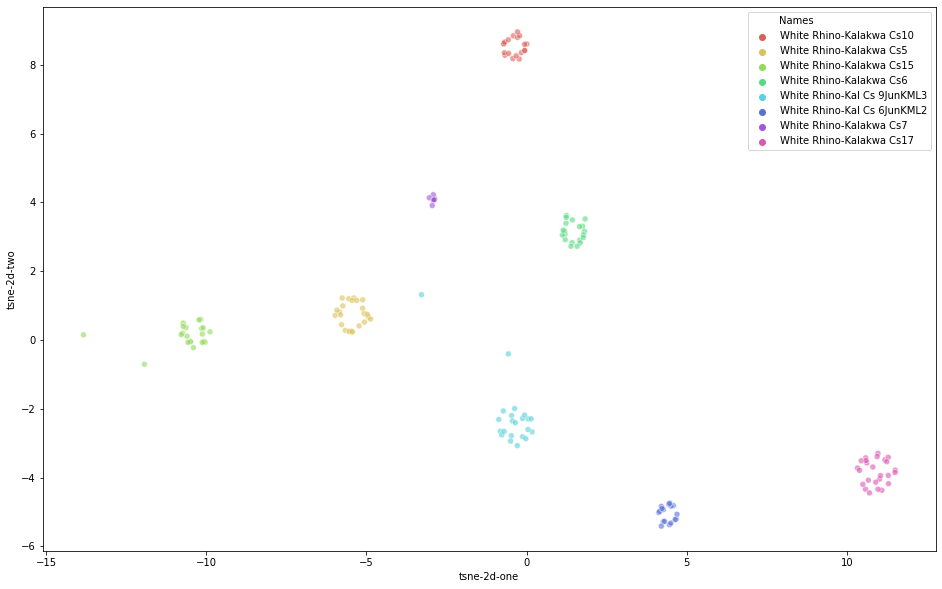

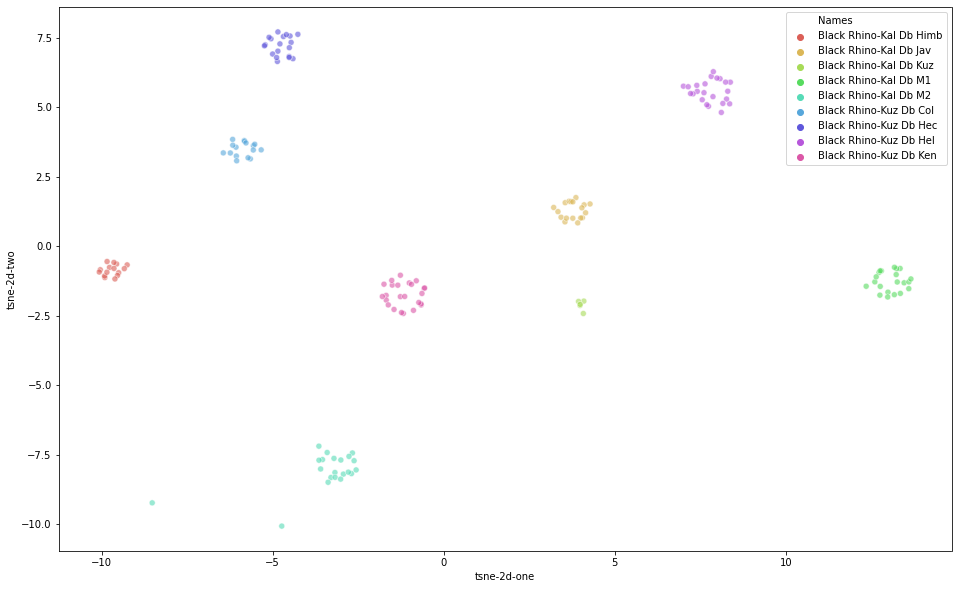

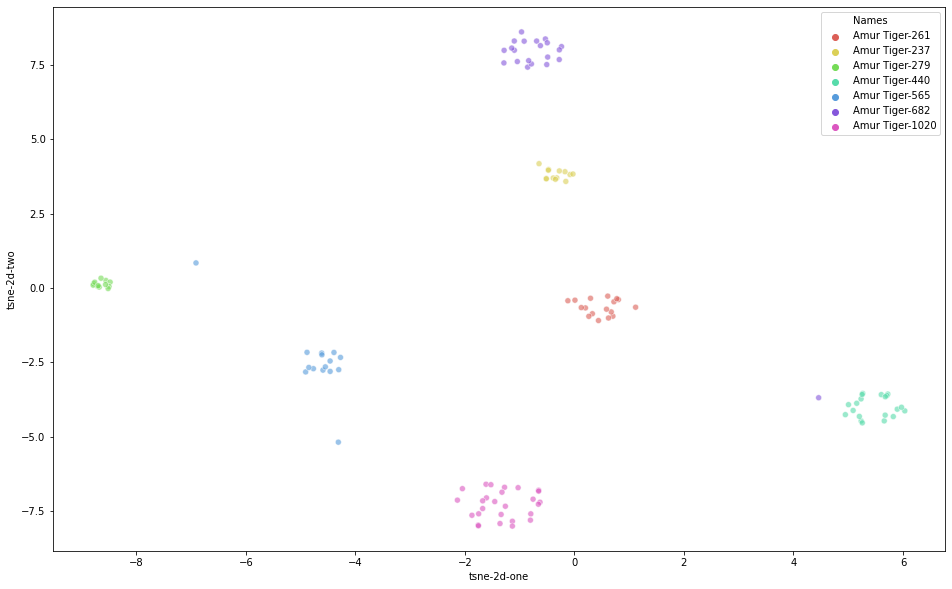

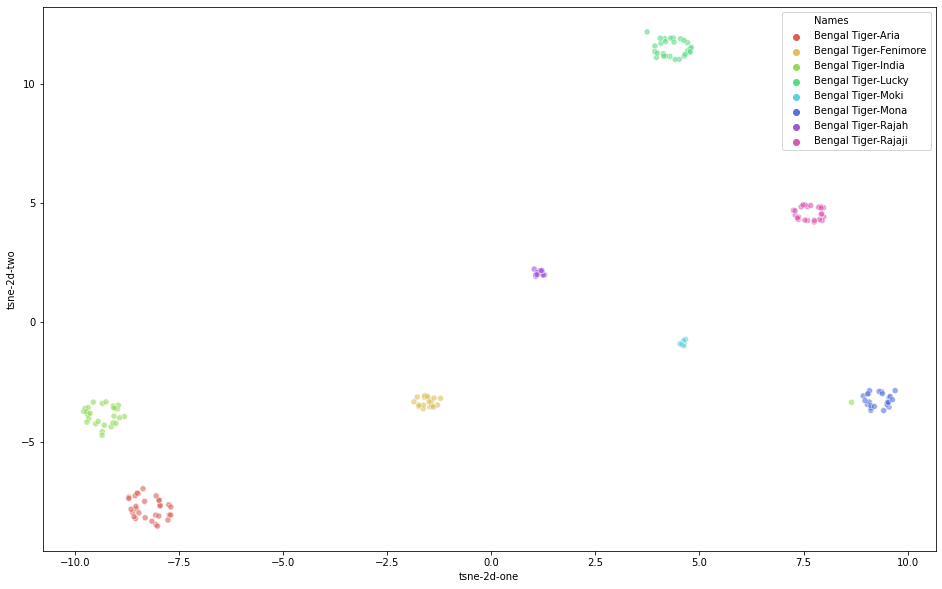

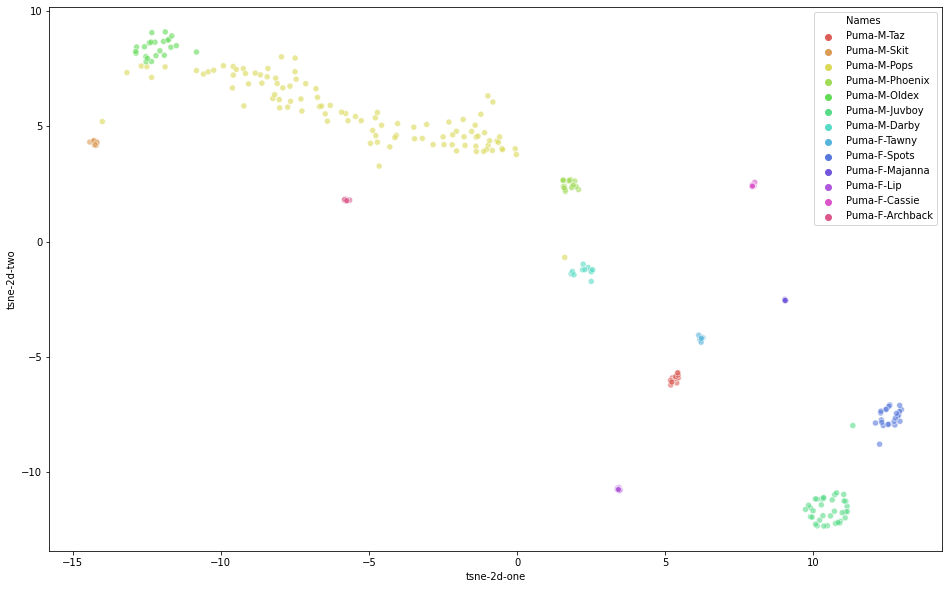

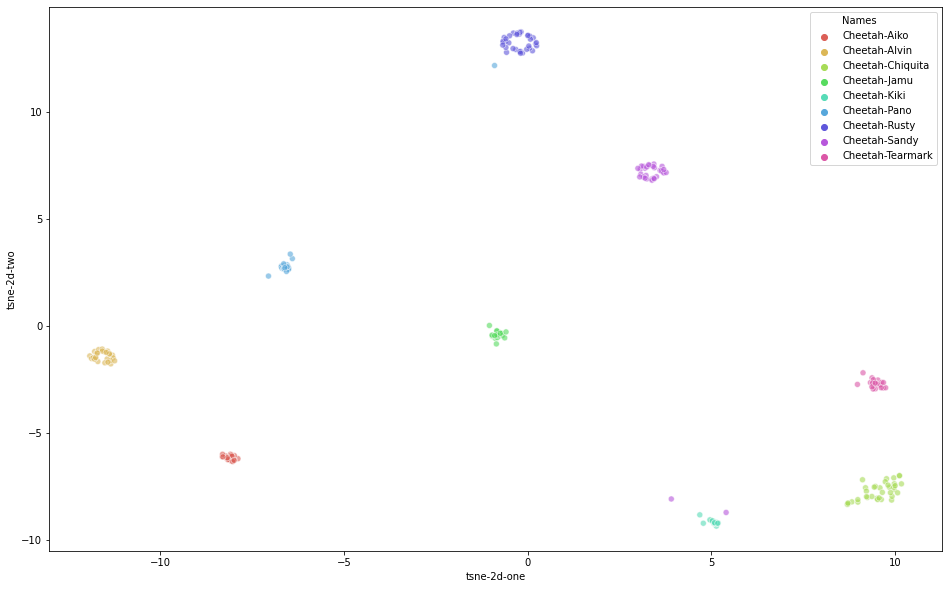

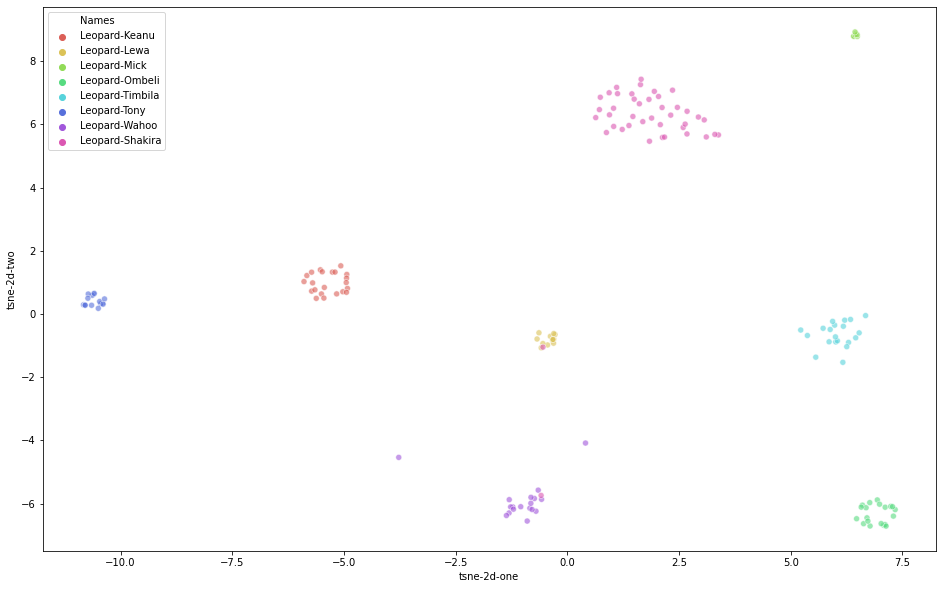

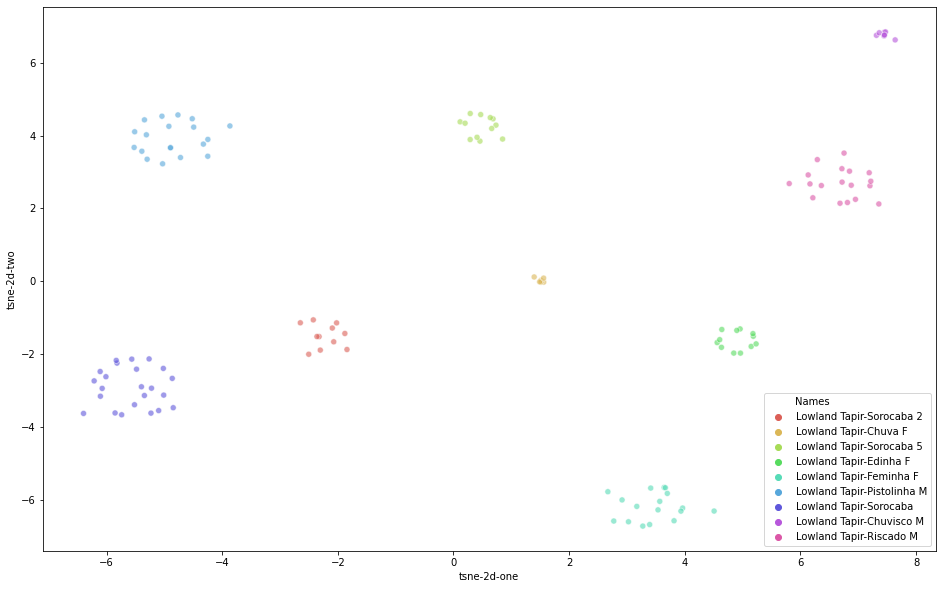

In [25]:
#Plot projected 2D clusters for each species
plotprints(df_WRhino)
plotprints(df_BRhino)
plotprints(df_ATiger)
plotprints(df_BTiger)
plotprints(df_Puma)
plotprints(df_Cheetah)
plotprints(df_Leopard)
plotprints(df_LTapir)

# MobileNetV2 - UNDER CONSTRUCTION

Placeholder Section to reproduce work done above (with VGG16) using MobileNet V2 . 
Note: INCOMPLETE: Needs to be completed

In [0]:
input_shape=(224,224,3)
mnet=MobileNetV2(weights='imagenet',include_top=False,input_shape=input_shape)
mnet.summary()

In [0]:
# Load Pre-Processed Images
  csvpath='/content/drive/My Drive/U C Berkeley - Darragh/csv'
  X,Species,Individuals, Ind_DB,X_Test,Species_Test,Individuals_Test=LoadData("Train-Images-Mobile-224.csv","Train-Labels-Mobile-224.txt","Test-Images-Mobile-224.csv","Test-Labels-Mobile-224.txt")

In [0]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
le = LabelEncoder()
le.fit(Species)
Y=le.transform(Species)
Y_Test=le.transform(Species_Test)
Y1=to_categorical(np.array(Y))
Y_Test1=to_categorical(np.array(Y_Test))
print(Y1.shape)
print(le.classes_)
#For Species Classification
from sklearn.model_selection import train_test_split

X_Train, X_Val, Y_Train, Y_Val = train_test_split(X, Y1, test_size=0.10, random_state=42)

In [0]:

mnet_model=Sequential()
mnet_model.add(mnet)
mnet_model.add(Flatten())
mnet_model.add(Dense(128, activation='relu',name="Dense1"))
mnet_model.add(Dense(64, activation='relu',name="Dense2"))
mnet_model.add(Dropout(0.8))
mnet_model.add(Dense(8))

mnet_model.summary()

In [0]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
mnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001),
              loss=loss_fn,
              metrics=['accuracy'])
mnet_model.fit(X_Train,Y_Train,validation_data=(X_Val,Y_Val),epochs=50)

In [0]:
mnet_model.evaluate(X_Test,  Y_Test1, verbose=2)

### Identification Task

In [0]:
mnet_model.summary()

In [0]:
triplet_model=Model(inputs=mnet_model.input,outputs=mnet_model.get_layer('Dense1').output)
triplet_model.summary()

In [0]:
input_shape=[224,224,3]
X1=Input(input_shape)
X2=Input(input_shape)
X3=Input(input_shape)
encoded1 = triplet_model(X1)
encoded2 = triplet_model(X2)
encoded3 = triplet_model(X3)

concat_vector=concatenate([encoded1,encoded2,encoded3],axis=-1,name='concat')
model=Model(inputs=[X1,X2,X3],outputs=concat_vector)
model.compile(loss=triplet_loss,optimizer=Adam(0.00001))
model.summary()

In [0]:
triples,targets=GetTriples(1500,True)
Anchor = triples[0]
Positive = triples[1]
Negative = triples[2]
Y=targets

model.fit([Anchor,Positive,Negative],y=targets, batch_size=40, epochs=60,verbose=2)

In [0]:
model.save_weights("ind-model-mnet.h5")
trained_model=Model(inputs=X1,outputs=encoded1)
trained_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
trained_model.load_weights("ind-model-mnet.h5")

num=len(X_Test)
correct=0
X_encoded=trained_model.predict(X_Test)

for i in range(num):
  #img=x = np.expand_dims(X_Test[i], axis=0)
  #X_encoded=trained_model.predict(X_Test[i])  
  test_data=[X_encoded[i],Species_Test[i]]
  true=Individuals_Test[i]
  predicted,silver,bronze=Validate(test_data,Ind_DB,trained_model)
  print(true,predicted,silver,bronze)
  if true==predicted:
    correct=correct+1
Accuracy=correct/num
print("Accuracy = ",Accuracy)